<a href="https://colab.research.google.com/github/Apaulgithub/Variants-of-Anomaly-Detector/blob/main/CNN_GRU_Anomaly_detector.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Import necessary libraries
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Step 1: Load and preprocess data
df = pd.read_csv("/content/drive/MyDrive/practice/ecg.csv", header=None)

X = df.iloc[:, :-1].values
y = df.iloc[:, -1].values

print("Dataset shape:", X.shape)

print("Class distribution:", np.unique(y, return_counts=True))

Dataset shape: (4998, 140)
Class distribution: (array([0., 1.]), array([2079, 2919]))


In [ ]:
# Normalize input data between 0 and 1
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

# Split into Train/Val/Test
X_train, X_temp, y_train, y_temp = train_test_split(X_scaled, y, test_size=0.3, random_state=42, stratify=y)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)

print("Train:", X_train.shape, "Val:", X_val.shape, "Test:", X_test.shape)

Train: (3498, 140) Val: (750, 140) Test: (750, 140)


In [ ]:
# Convert to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
X_val_tensor   = torch.tensor(X_val, dtype=torch.float32)
X_test_tensor  = torch.tensor(X_test, dtype=torch.float32)

y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
y_val_tensor   = torch.tensor(y_val, dtype=torch.float32)
y_test_tensor  = torch.tensor(y_test, dtype=torch.float32)

# Datasets and loaders
train_data = torch.utils.data.TensorDataset(X_train_tensor, y_train_tensor)
val_data   = torch.utils.data.TensorDataset(X_val_tensor, y_val_tensor)
test_data  = torch.utils.data.TensorDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_data, batch_size=1, shuffle=True)
val_loader   = DataLoader(val_data, batch_size=1, shuffle=False)
test_loader  = DataLoader(test_data, batch_size=1, shuffle=False)

In [ ]:
class CNN_3GRU_Model(nn.Module):
    def __init__(self, input_dim, hidden_size=64, num_classes=1):
        super(CNN_3GRU_Model, self).__init__()

        # --- CNN part ---
        self.cnn = nn.Sequential(
            nn.Conv1d(1, 32, kernel_size=5, stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=2),  # 140 → 70
            nn.Conv1d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=2)   # 70 → 35
        )

        # --- Stacked GRUs ---
        self.gru = nn.GRU(
            input_size=64,      # CNN features
            hidden_size=hidden_size,
            num_layers=3,       # 3 GRU layers
            batch_first=True,
            bidirectional=True
        )

        # --- Fully connected classifier ---
        self.fc = nn.Sequential(
            nn.Linear(hidden_size*2, 64),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(64, num_classes),
            nn.Sigmoid()
        )

    def forward(self, x):
        # x: [B, seq_len]
        x = x.unsqueeze(1)                  # [B, 1, seq_len]
        cnn_out = self.cnn(x)               # [B, 64, seq_len//4]
        cnn_out = cnn_out.permute(0, 2, 1)  # [B, seq_len//4, 64] for GRU
        gru_out, _ = self.gru(cnn_out)      # [B, seq_len//4, hidden*2]
        final_feat = gru_out[:, -1, :]      # last timestep
        out = self.fc(final_feat)
        return out.view(-1)                  # ensures shape [B]

In [ ]:
# 4. Training setup
# =====================================================
device = "cuda" if torch.cuda.is_available() else "cpu"
model = CNN_3GRU_Model(input_dim=X.shape[1]).to(device)
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

EPOCHS = 100
patience = 10
best_val_loss = float('inf')
epochs_no_improve = 0

train_losses, val_losses = [], []

# =====================================================
# 5. Training Loop
# =====================================================
for epoch in range(EPOCHS):
    model.train()
    total_train_loss = 0

    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)
        optimizer.zero_grad()
        outputs = model(xb)
        loss = criterion(outputs, yb)
        loss.backward()
        optimizer.step()
        total_train_loss += loss.item() * xb.size(0)

    train_loss = total_train_loss / len(train_loader.dataset)
    train_losses.append(train_loss)

    # Validation
    model.eval()
    total_val_loss = 0
    with torch.no_grad():
        for xb, yb in val_loader:
            xb, yb = xb.to(device), yb.to(device)
            outputs = model(xb)
            loss = criterion(outputs, yb)
            total_val_loss += loss.item() * xb.size(0)
    val_loss = total_val_loss / len(val_loader.dataset)
    val_losses.append(val_loss)

    print(f"Epoch [{epoch+1}/{EPOCHS}] Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")

    # Early stopping
    if val_loss < best_val_loss - 1e-4:
        best_val_loss = val_loss
        epochs_no_improve = 0
        torch.save(model.state_dict(), "best_cnn_gru.pth")
    else:
        epochs_no_improve += 1
        if epochs_no_improve >= patience:
            print(f"Early stopping at epoch {epoch+1}")
            break

# Load best model
model.load_state_dict(torch.load("best_cnn_gru.pth"))

Epoch [1/100] Train Loss: 0.2108, Val Loss: 0.0673
Epoch [2/100] Train Loss: 0.1138, Val Loss: 0.0430
Epoch [3/100] Train Loss: 0.0797, Val Loss: 0.0434
Epoch [4/100] Train Loss: 0.1081, Val Loss: 0.0661
Epoch [5/100] Train Loss: 0.0789, Val Loss: 0.0958
Epoch [6/100] Train Loss: 0.0842, Val Loss: 0.0566
Epoch [7/100] Train Loss: 0.0571, Val Loss: 0.0297
Epoch [8/100] Train Loss: 0.0509, Val Loss: 0.0430
Epoch [9/100] Train Loss: 0.0480, Val Loss: 0.0476
Epoch [10/100] Train Loss: 0.0740, Val Loss: 0.0490
Epoch [11/100] Train Loss: 0.0381, Val Loss: 0.0706
Epoch [12/100] Train Loss: 0.0446, Val Loss: 0.0295
Epoch [13/100] Train Loss: 0.0448, Val Loss: 0.0741
Epoch [14/100] Train Loss: 0.0386, Val Loss: 0.0391
Epoch [15/100] Train Loss: 0.0315, Val Loss: 0.0291
Epoch [16/100] Train Loss: 0.0475, Val Loss: 0.0601
Epoch [17/100] Train Loss: 0.0455, Val Loss: 0.0582
Epoch [18/100] Train Loss: 0.0534, Val Loss: 0.0406
Epoch [19/100] Train Loss: 0.0446, Val Loss: 0.0347
Epoch [20/100] Train 

<All keys matched successfully>

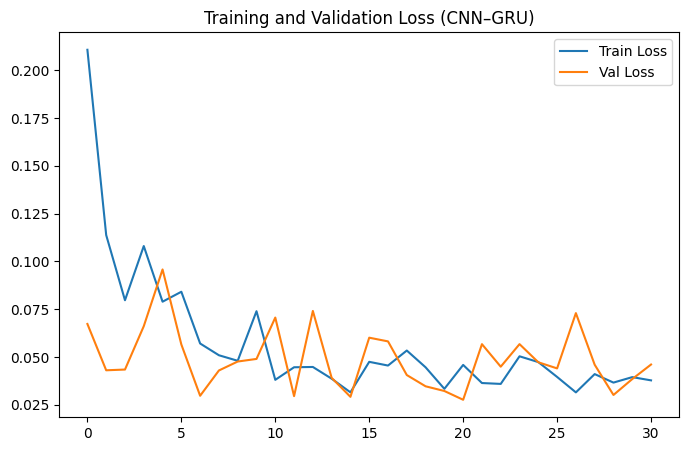

In [ ]:
# 6. Plot Loss Curves
# =====================================================
plt.figure(figsize=(8,5))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.legend()
plt.title("Training and Validation Loss (CNN–GRU)")
plt.show()

In [ ]:
# 7. Evaluation
# =====================================================
model.eval()
y_true, y_pred = [], []

with torch.no_grad():
    for xb, yb in test_loader:
        xb = xb.to(device)
        outputs = model(xb)
        preds = (outputs.cpu().numpy() > 0.5).astype(int)
        y_true.extend(yb.numpy())
        y_pred.extend(preds)

y_true, y_pred = np.array(y_true), np.array(y_pred)

print("\nEvaluation Results:")
print(f"Accuracy : {accuracy_score(y_true, y_pred)*100:.2f}%")
print(f"Precision: {precision_score(y_true, y_pred)*100:.2f}%")
print(f"Recall   : {recall_score(y_true, y_pred)*100:.2f}%")
print(f"F1 Score : {f1_score(y_true, y_pred)*100:.2f}%")

cm = confusion_matrix(y_true, y_pred)
print("\nConfusion Matrix:\n", cm)


Evaluation Results:
Accuracy : 99.33%
Precision: 99.54%
Recall   : 99.32%
F1 Score : 99.43%

Confusion Matrix:
 [[310   2]
 [  3 435]]
